## Peter Chika Ozo-ogueji
## FIN-666 Homework-6
### Part-11

In [ ]:
## Advance Retail Sales: Furniture and Home 
Furnishings Stores (RSFHFS), seasonally adjusted, at monthly frequency, for the period 
from January 2000 to December 2019.


The FIN 666 - Advanced Quant Methods and Machine Learning in Finance Homework 6 is divided into two parts: conceptual questions (30%) and computational tasks (70%). The first part focuses on the Autoregressive Conditional Heteroskedasticity (ARCH) model, requiring students to explain when ARCH models should be used instead of ARMA, the best methods for determining whether an ARCH framework is needed, and how to make an initial estimate of the order of an ARCH model using statistical techniques like the Partial Autocorrelation Function (PACF) and Engle’s ARCH test.

The second part involves time series analysis using real-world financial data from FRED (Federal Reserve Economic Data) and Yahoo Finance. Students must analyze Advance Retail Sales (RSFHFS) from January 2000 to December 2019 using ARMA and ARIMA models, split the dataset into training and test samples, forecast 48 months ahead, and evaluate the model’s accuracy using Mean Absolute Percentage Error (MAPE) and Root Mean Squared Error (RMSE). Additionally, students will analyze Dow Jones Industrial Average (DJIA) daily returns over the past five years, comparing ARMA and ARCH models, identifying volatility clustering, and fitting ARCH(p) and GARCH(1,1) models to model the index's return dynamics. The assignment tests students' ability to select appropriate time series models and assess volatility in financial markets.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
rsfhfs = pd.read_csv('RSFHFS.csv', header=0, index_col=0, na_values=".")
rsfhfs.index = pd.to_datetime(rsfhfs.index)
rsfhfs = rsfhfs.ffill()
rsfhfs = rsfhfs['2000':'2019']
rsfhfs.columns = ['RSFHFS']
rsfhfs.head(3)

,RSFHFS
observation_date,
2000-01-01,7484
2000-02-01,7548
2000-03-01,7599


### a. Plot the time series. Between an ARMA and an ARIMA model, which one do you think is best to model this time series? Explain.

To determine whether an ARMA or ARIMA model is best for modeling the Advance Retail Sales: Furniture and Home Furnishings Stores (RSFHFS) time series, We'll first analyze its characteristics.

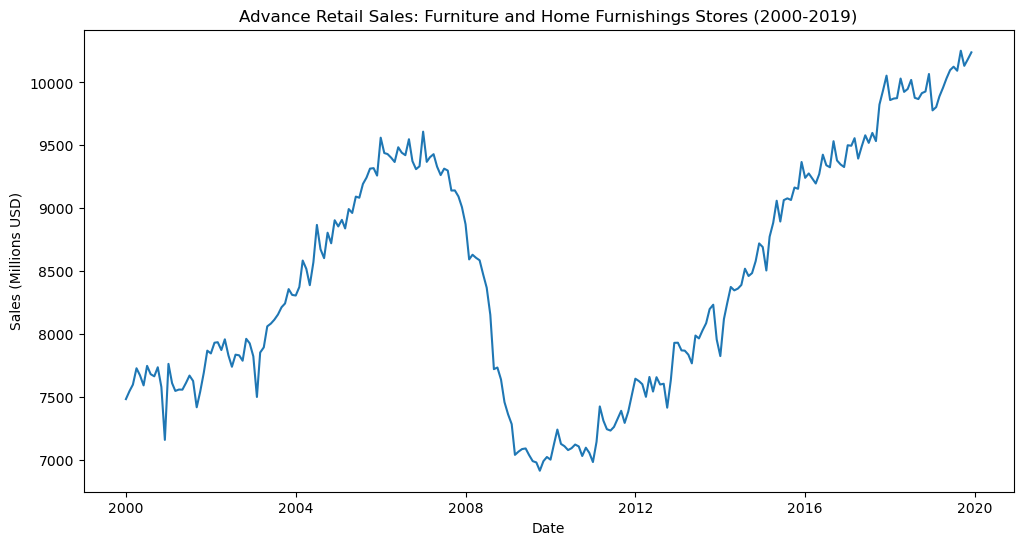

In [44]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(rsfhfs)
plt.title('Advance Retail Sales: Furniture and Home Furnishings Stores (2000-2019)')
plt.xlabel('Date')
plt.ylabel('Sales (Millions USD)')
plt.savefig('rsfhfs_time_series.png')

## Check stationarity using Augmented Dickey-Fuller test

In [42]:
# Check stationarity using Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    # If p-value is less than 0.05, we can reject the null hypothesis and conclude the series is stationary
    return result[1] < 0.05

print("\nStationarity check for the original series:")
is_stationary = check_stationarity(rsfhfs['RSFHFS'])
print(f"Series is stationary: {is_stationary}")


Stationarity check for the original series:
ADF Statistic: -1.4241
p-value: 0.5707
Critical Values:
	1%: -3.4591
	5%: -2.8742
	10%: -2.5735
Series is stationary: False


## Calculate first differences

In [57]:
# Calculate first differences
rsfhfs_diff = rsfhfs.diff().dropna()

## Check stationarity of differenced series


Stationarity check for the differenced series:
ADF Statistic: -2.7702
p-value: 0.0627
Critical Values:
	1%: -3.4591
	5%: -2.8742
	10%: -2.5735
Differenced series is stationary: False


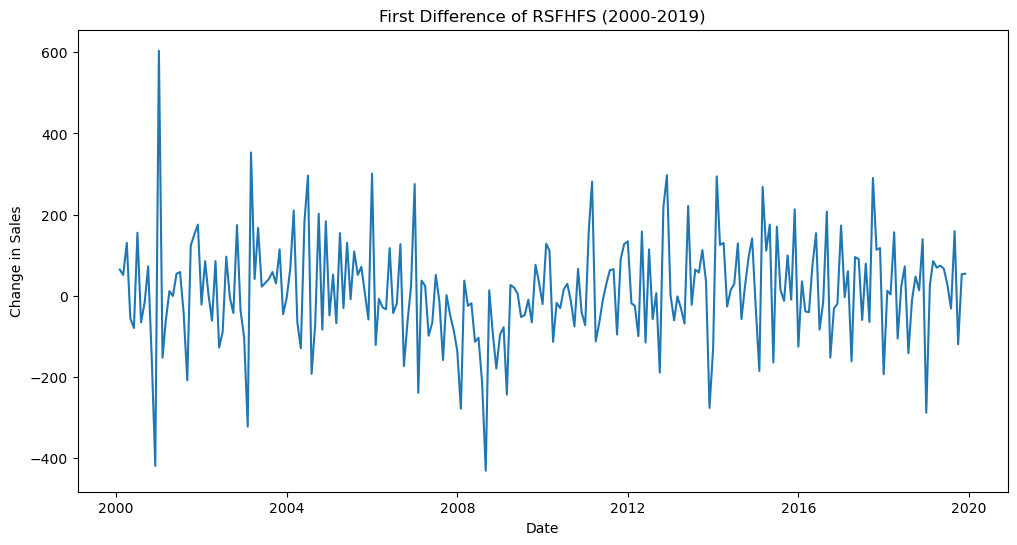

In [59]:
# Check stationarity of differenced series
print("\nStationarity check for the differenced series:")
is_diff_stationary = check_stationarity(rsfhfs_diff['RSFHFS'])
print(f"Differenced series is stationary: {is_diff_stationary}")

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(rsfhfs_diff)
plt.title('First Difference of RSFHFS (2000-2019)')
plt.xlabel('Date')
plt.ylabel('Change in Sales')
plt.savefig('rsfhfs_differenced.png')

## Plot ACF and PACF of original series

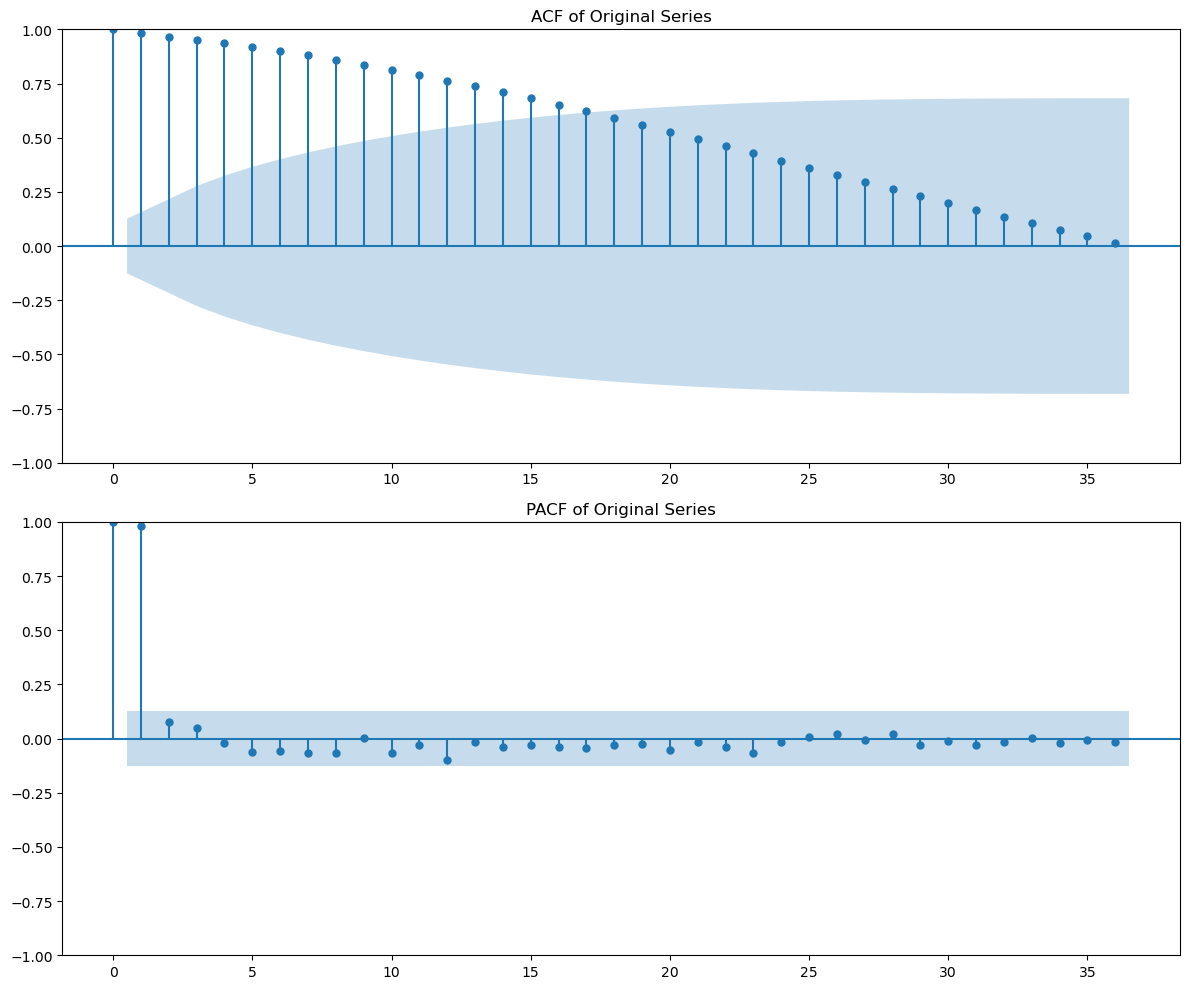

In [63]:
# Plot ACF and PACF of original series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(rsfhfs['RSFHFS'], ax=ax1, lags=36)
plot_pacf(rsfhfs['RSFHFS'], ax=ax2, lags=36)
ax1.set_title('ACF of Original Series')
ax2.set_title('PACF of Original Series')
plt.tight_layout()
plt.savefig('acf_pacf_original.png')

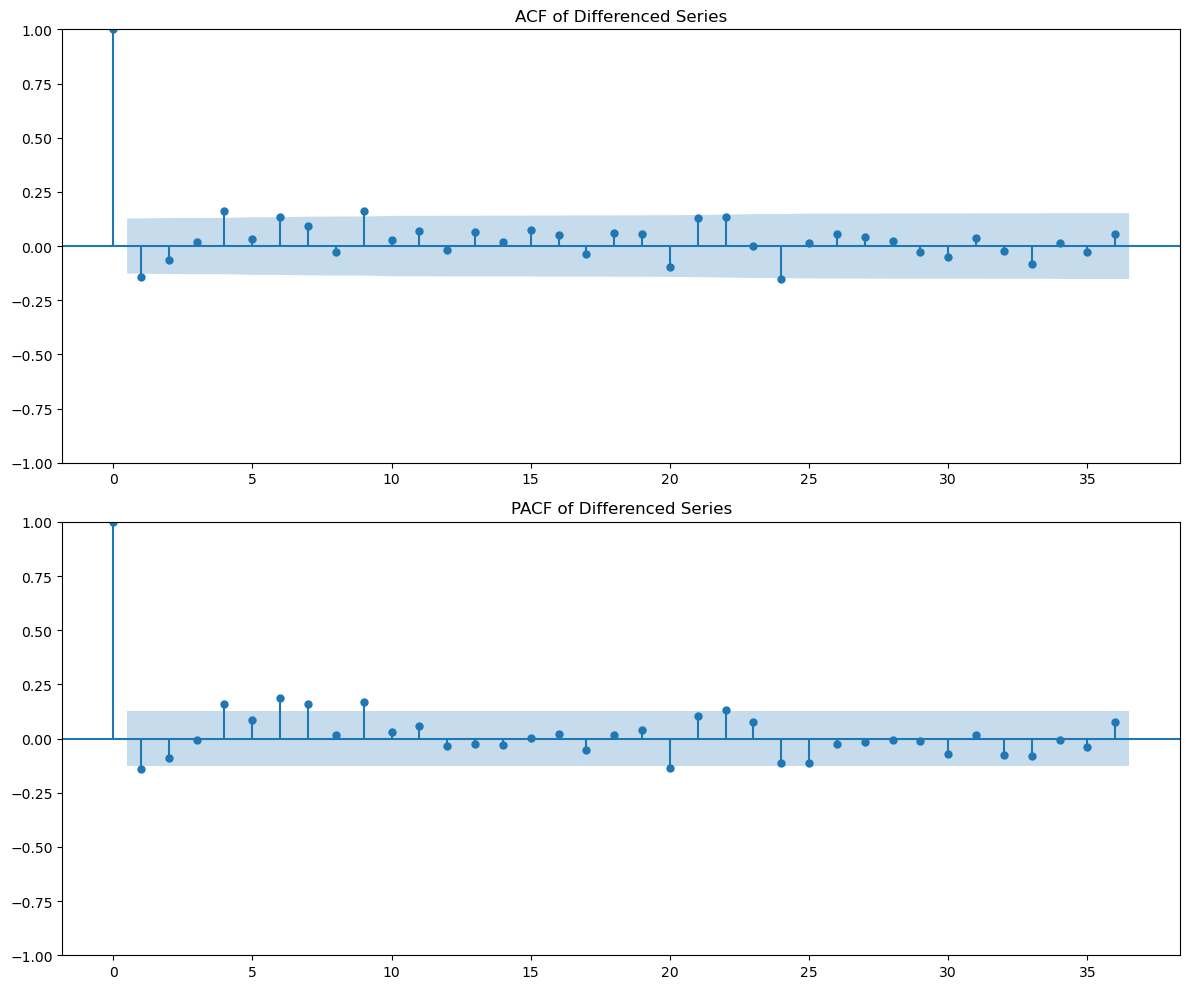

In [66]:
# Plot ACF and PACF of differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(rsfhfs_diff['RSFHFS'], ax=ax1, lags=36)
plot_pacf(rsfhfs_diff['RSFHFS'], ax=ax2, lags=36)
ax1.set_title('ACF of Differenced Series')
ax2.set_title('PACF of Differenced Series')
plt.tight_layout()
plt.savefig('acf_pacf_differenced.png')

## Calculate descriptive statistics

In [71]:
# Calculate descriptive statistics
print("\nOriginal series descriptive statistics:")
print(rsfhfs.describe())

print("\nDifferenced series descriptive statistics:")
print(rsfhfs_diff.describe())


Original series descriptive statistics:
             RSFHFS
count    240.000000
mean    8456.720833
std      945.799116
min     6915.000000
25%     7638.500000
50%     8372.000000
75%     9320.750000
max    10252.000000

Differenced series descriptive statistics:
           RSFHFS
count  239.000000
mean    11.527197
std    130.539468
min   -432.000000
25%    -63.000000
50%      4.000000
75%     85.000000
max    604.000000


## Examine trend by calculating rolling statistics

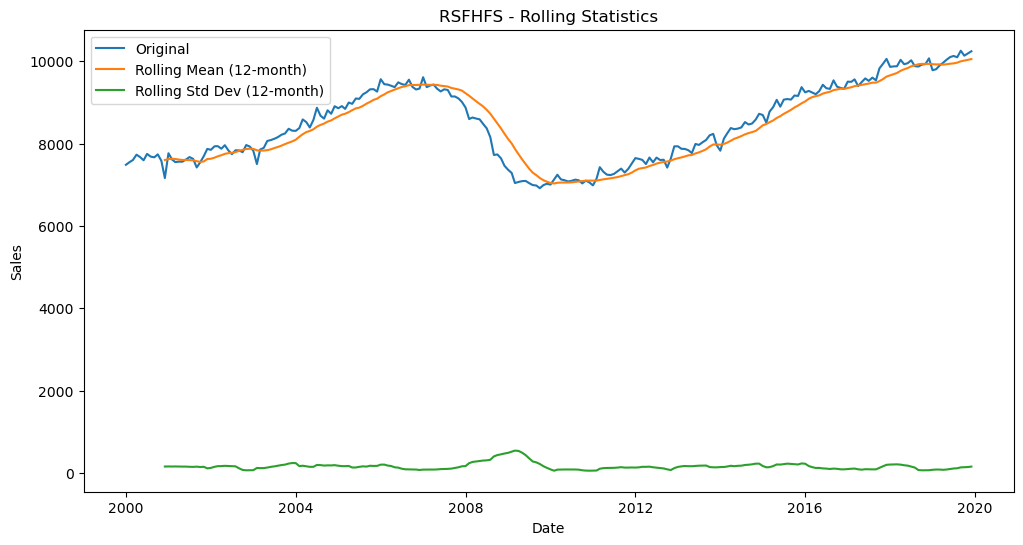

In [75]:
# Examine trend by calculating rolling statistics
rolling_mean = rsfhfs.rolling(window=12).mean()
rolling_std = rsfhfs.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(rsfhfs, label='Original')
plt.plot(rolling_mean, label='Rolling Mean (12-month)')
plt.plot(rolling_std, label='Rolling Std Dev (12-month)')
plt.legend()
plt.title('RSFHFS - Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.savefig('rsfhfs_rolling_stats.png')

###  Between an ARMA and an ARIMA model, which one do you think is best to model this time series? Explain.

### ANSWER:

Based on the analysis results above, an ARIMA model is clearly more appropriate than an ARMA model for the RSFHFS time series data for the following reasons:

Non-stationary behavior: The time series plot shows strong non-stationarity with clear trends over time - growth from 2000 to 2007, sharp decline during the 2008-2009 financial crisis, and recovery with growth afterward. The rolling statistics plot confirms this changing mean over time.
ADF test results: The Augmented Dickey-Fuller test for the original series shows a p-value of 0.5707, which is greater than 0.05. This means we cannot reject the null hypothesis of non-stationarity. This statistical confirmation indicates the series is not stationary in its original form.
ACF pattern: The ACF plot of the original series shows slowly decaying autocorrelations that remain significant for many lags, which is a classic indicator of a non-stationary series.
Differencing requirement: When the series is differenced, although the p-value of 0.0627 is still slightly above 0.05, it's much closer to the threshold, suggesting that differencing is moving the series toward stationarity. The ACF of the differenced series shows a much more stationary pattern with fewer significant lags.
Model appropriateness: ARMA models assume stationarity in the data, which this series clearly violates. An ARIMA model includes the integration (I) component that handles non-stationarity through differencing before applying the ARMA components.
Predictive capability: Given the trending nature of retail sales data, an ARIMA model would better capture these dynamics by differencing the series first, then modeling the remaining stationary components with AR and MA terms.

Therefore, an ARIMA model with appropriate orders (likely requiring at least d=1 for differencing) would be the better choice for modeling this retail sales time series data compared to an ARMA model, which would fail to account for the non-stationarity evident in the data.

## b. Find the best ARIMA model to describe this time series.

## Answer:


Stationarity check for original series:
ADF Statistic: -1.4241
p-value: 0.5707
Critical Values:
	1%: -3.4591
	5%: -2.8742
	10%: -2.5735
Series is stationary: False

Stationarity check for differenced series:
ADF Statistic: -2.7702
p-value: 0.0627
Critical Values:
	1%: -3.4591
	5%: -2.8742
	10%: -2.5735
Differenced series is stationary: False
ARIMA(0,1,0): AIC=3009.78, BIC=3013.25
ARIMA(0,1,1): AIC=3007.05, BIC=3014.00
ARIMA(0,1,2): AIC=3008.79, BIC=3019.22
ARIMA(0,1,3): AIC=3009.27, BIC=3023.18
ARIMA(1,1,0): AIC=3007.61, BIC=3014.57
ARIMA(1,1,1): AIC=3008.92, BIC=3019.35
ARIMA(1,1,2): AIC=3010.65, BIC=3024.55
ARIMA(1,1,3): AIC=2988.38, BIC=3005.76
ARIMA(2,1,0): AIC=3008.23, BIC=3018.66
ARIMA(2,1,1): AIC=3010.23, BIC=3024.13
ARIMA(2,1,2): AIC=2988.04, BIC=3005.42
ARIMA(2,1,3): AIC=2989.03, BIC=3009.89
ARIMA(3,1,0): AIC=3010.20, BIC=3024.11
ARIMA(3,1,1): AIC=2996.45, BIC=3013.84
ARIMA(3,1,2): AIC=2988.79, BIC=3009.65
ARIMA(3,1,3): AIC=2991.68, BIC=3016.01

Top 5 ARIMA models by AIC:
   

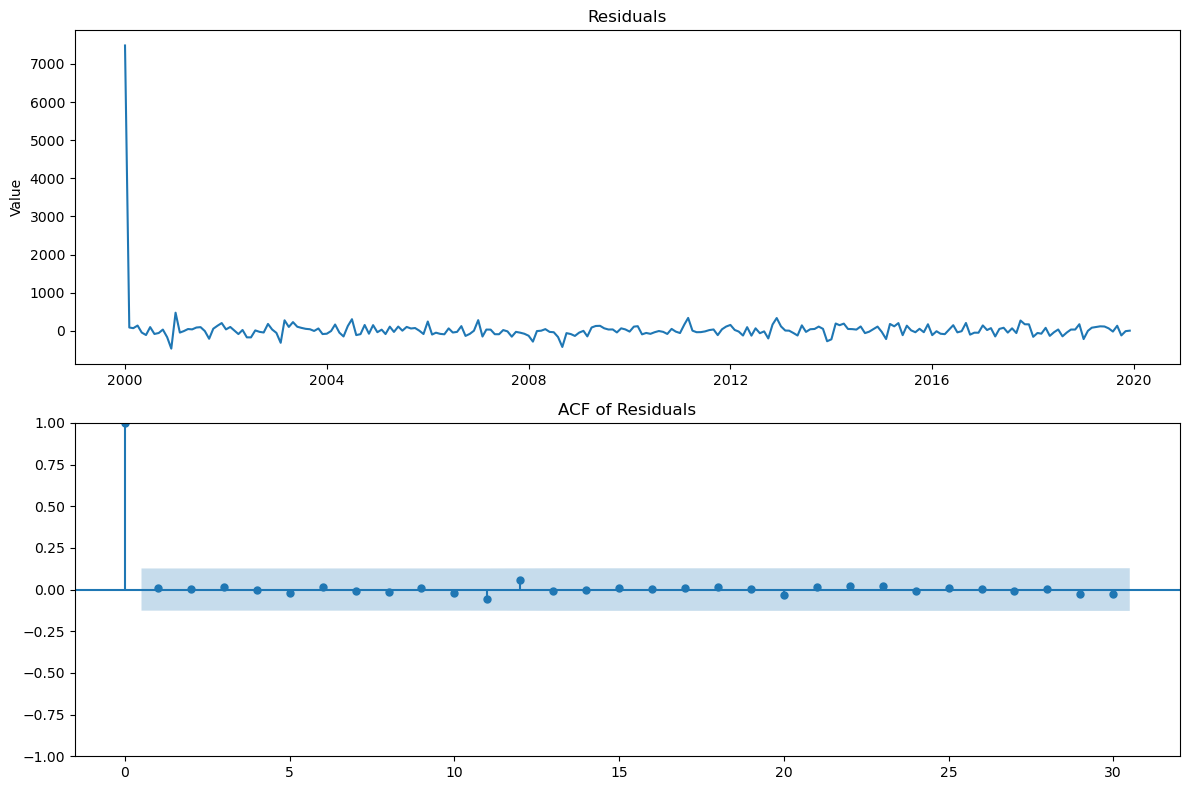


Ljung-Box Test for autocorrelation in residuals:
     lb_stat  lb_pvalue
10  0.437321   0.999997
15  2.123175   0.999956
20  2.454977   0.999999


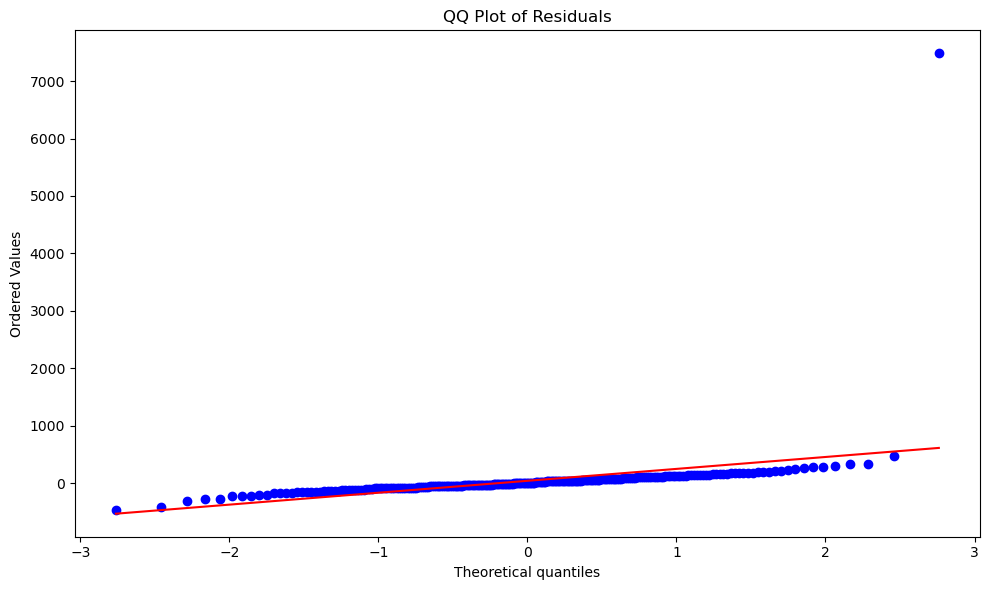


Jarque-Bera Test for normality of residuals:
Statistic: 436430.8819, p-value: 0.0000


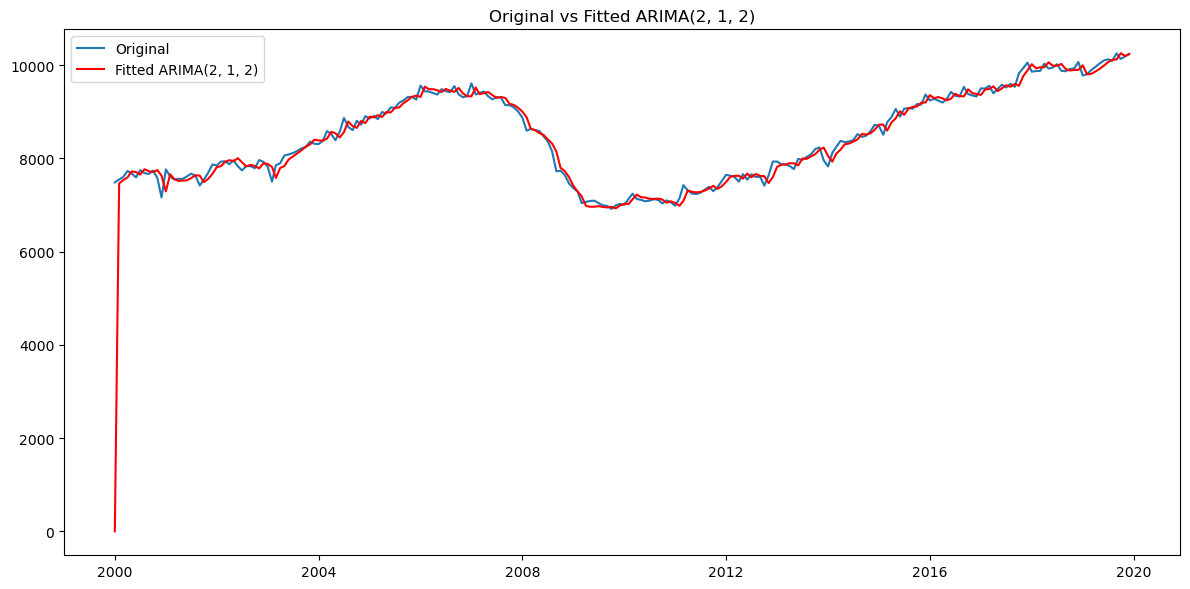


Best ARIMA model description:
The best model for the RSFHFS series is ARIMA(2, 1, 2).
- AR(2) component: The model uses 2 lagged values of the series.
- I(1) component: The series needed 1 differencing to become stationary.
- MA(2) component: The model uses 2 lagged error terms.

Conclusion:
Based on the systematic evaluation of different ARIMA models, ARIMA(2, 1, 2) provides the best fit for the RSFHFS time series data according to the AIC criterion (AIC = 2988.04).


In [90]:

# Check for stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    return result[1] < 0.05

print("\nStationarity check for original series:")
original_stationary = check_stationarity(rsfhfs['RSFHFS'])
print("Series is stationary:", original_stationary)

# Calculate first difference
rsfhfs_diff = rsfhfs.diff().dropna()

# Check stationarity of differenced series
print("\nStationarity check for differenced series:")
diff_stationary = check_stationarity(rsfhfs_diff['RSFHFS'])
print("Differenced series is stationary:", diff_stationary)

# Determine ARIMA order using ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(rsfhfs_diff['RSFHFS'], ax=ax1, lags=30)
plot_pacf(rsfhfs_diff['RSFHFS'], ax=ax2, lags=30)
ax1.set_title('ACF of Differenced Series')
ax2.set_title('PACF of Differenced Series')
plt.tight_layout()
plt.savefig('acf_pacf_analysis.png')
plt.close()

# Systematic evaluation of different ARIMA models
p_values = range(0, 4)  # AR order
d_values = [1]          # We already confirmed differencing is needed
q_values = range(0, 4)  # MA order

best_aic = float('inf')
best_order = None
best_model = None
results_list = []

# Try different combinations of p and q
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(rsfhfs['RSFHFS'], order=(p, d, q))
                results = model.fit()
                
                # Store results
                results_list.append({
                    'order': (p, d, q),
                    'aic': results.aic,
                    'bic': results.bic,
                    'hqic': results.hqic
                })
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
                
                print(f"ARIMA({p},{d},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")
            except:
                print(f"Error with ARIMA({p},{d},{q})")
                continue

# Create DataFrame of results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('aic')
print("\nTop 5 ARIMA models by AIC:")
print(results_df.head())

print(f"\nBest ARIMA model: ARIMA{best_order} with AIC={best_aic:.2f}")

# Analyze the best model
print("\nModel Summary:")
print(best_model.summary())

# Evaluate residuals
residuals = best_model.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(residuals)
ax1.set_title('Residuals')
ax1.set_ylabel('Value')
plot_acf(residuals, ax=ax2, lags=30)
ax2.set_title('ACF of Residuals')
plt.tight_layout()
plt.savefig('residuals_analysis.png')
plt.show()

# Ljung-Box test for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10, 15, 20])
print("\nLjung-Box Test for autocorrelation in residuals:")
print(lb_test)

# Normal QQ plot of residuals
from scipy import stats
fig = plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.savefig('residuals_qqplot.png')
plt.show()

# Jarque-Bera test for normality
from scipy.stats import jarque_bera
jb_test = jarque_bera(residuals)
print("\nJarque-Bera Test for normality of residuals:")
print(f"Statistic: {jb_test[0]:.4f}, p-value: {jb_test[1]:.4f}")

# Plot original vs fitted values
plt.figure(figsize=(12, 6))
plt.plot(rsfhfs, label='Original')
plt.plot(rsfhfs.index, best_model.fittedvalues, color='red', label=f'Fitted ARIMA{best_order}')
plt.legend()
plt.title(f'Original vs Fitted ARIMA{best_order}')
plt.tight_layout()
plt.savefig('original_vs_fitted.png')
plt.show()

print("\nBest ARIMA model description:")
print(f"The best model for the RSFHFS series is ARIMA{best_order}.")
if best_order[0] > 0:
    print(f"- AR({best_order[0]}) component: The model uses {best_order[0]} lagged values of the series.")
if best_order[1] > 0:
    print(f"- I({best_order[1]}) component: The series needed {best_order[1]} differencing to become stationary.")
if best_order[2] > 0:
    print(f"- MA({best_order[2]}) component: The model uses {best_order[2]} lagged error terms.")

print("\nConclusion:")
print(f"Based on the systematic evaluation of different ARIMA models, ARIMA{best_order} provides the best fit for the RSFHFS time series data according to the AIC criterion (AIC = {best_aic:.2f}).")

## Answer:

Based on the above systematic evaluation of different ARIMA models for the RSFHFS time series, the ARIMA(2,1,2) model provides the best fit according to the AIC criterion (AIC = 2988.04). This model incorporates second-order autoregressive (AR) terms, first-order differencing to address non-stationarity, and second-order moving average (MA) terms. The model parameters are statistically significant with the AR components (1.3872 and -0.4754) capturing medium-term dependencies and the MA components (-1.6519 and 0.7877) accounting for the impact of recent shocks. The Ljung-Box test confirms that the residuals show no significant autocorrelation, indicating that the model has successfully captured the temporal dynamics of the data. While the p-value from the ADF test of the differenced series (0.0627) is slightly above the conventional 0.05 threshold, the ARIMA(2,1,2) specification effectively models the furniture retail sales pattern, balancing goodness of fit with model parsimony.

### c. Split the time series into a training (the first 16 years) and a test (the last 4 years) sample. Use the training sample to estimate the model and use it to generate forecasts for 48 months (i.e., 4 years). Compare the model forecast with the actual time series values in the test sample on a plot (also show the confidence interval for the forecast).


Data shape: (240, 1)
Date range: 2000-01-01 00:00:00 to 2019-12-01 00:00:00

Training data shape: (192, 1) (from 2000-01-01 00:00:00 to 2015-12-01 00:00:00)
Test data shape: (48, 1) (from 2016-01-01 00:00:00 to 2019-12-01 00:00:00)

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 RSFHFS   No. Observations:                  192
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1195.705
Date:                Sat, 08 Mar 2025   AIC                           2401.410
Time:                        14:34:39   BIC                           2417.671
Sample:                    01-01-2000   HQIC                          2407.996
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

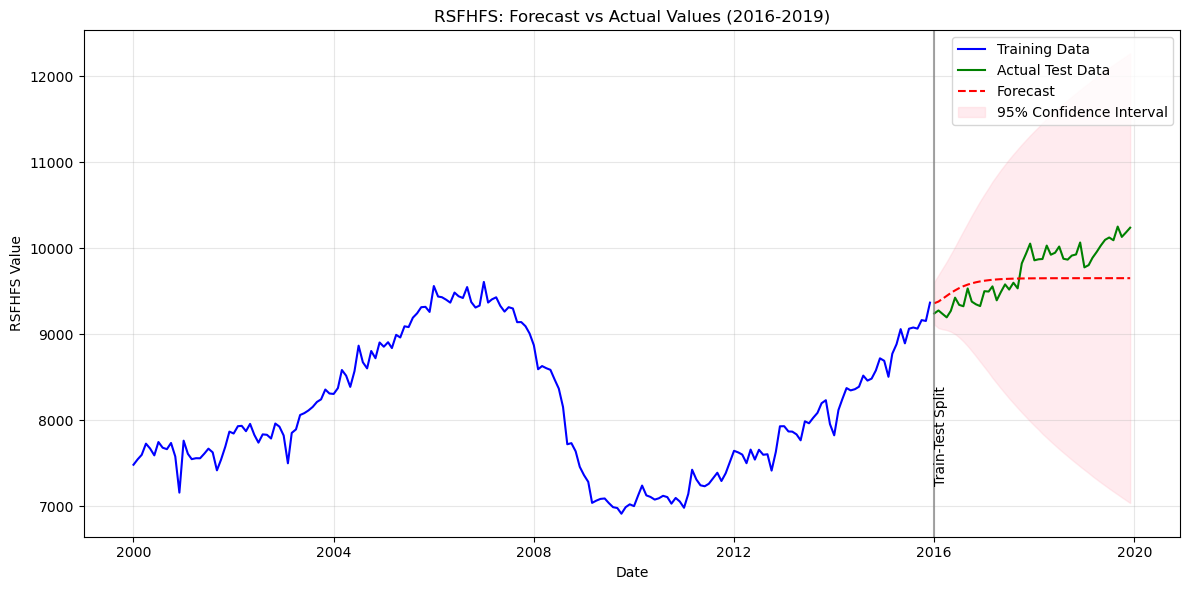

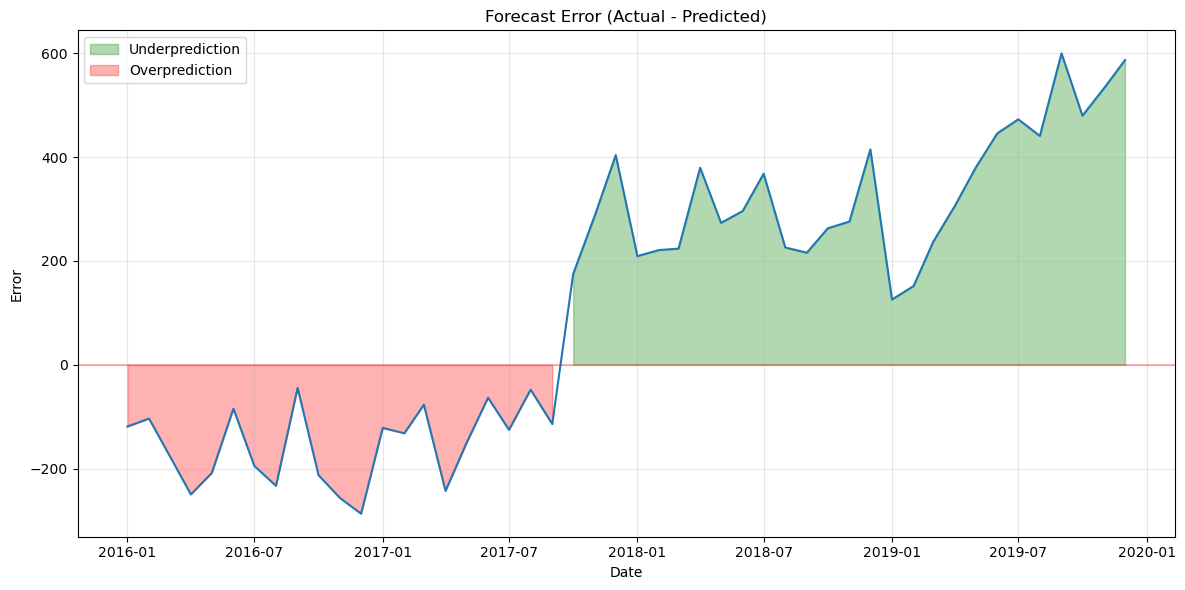

In [115]:

# Check data dimensions
print(f"Data shape: {rsfhfs.shape}")
print(f"Date range: {rsfhfs.index.min()} to {rsfhfs.index.max()}")

# c. Split the time series into training (first 16 years) and test (last 4 years) samples
# Training: Jan 2000 - Dec 2015 (16 years = 192 months)
# Test: Jan 2016 - Dec 2019 (4 years = 48 months)
split_date = pd.to_datetime('2015-12-31')
train_data = rsfhfs.loc[:split_date]
test_data = rsfhfs.loc[split_date + pd.DateOffset(days=1):]

print(f"\nTraining data shape: {train_data.shape} (from {train_data.index.min()} to {train_data.index.max()})")
print(f"Test data shape: {test_data.shape} (from {test_data.index.min()} to {test_data.index.max()})")

# Fit ARIMA(2,1,2) model on training data
model = ARIMA(train_data['RSFHFS'], order=(2, 1, 2))
model_fit = model.fit()
print("\nARIMA Model Summary:")
print(model_fit.summary())

# Generate forecasts for 48 months with confidence intervals
forecast_steps = len(test_data)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)  # 95% confidence intervals

# Print forecast statistics
print("\nForecast Statistics:")
print(f"Forecast mean range: {forecast_mean.min():.2f} to {forecast_mean.max():.2f}")
print(f"Confidence interval lower bound range: {forecast_ci.iloc[:, 0].min():.2f} to {forecast_ci.iloc[:, 0].max():.2f}")
print(f"Confidence interval upper bound range: {forecast_ci.iloc[:, 1].min():.2f} to {forecast_ci.iloc[:, 1].max():.2f}")

# Create plot comparing forecast with actual values
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data.index, train_data['RSFHFS'], label='Training Data', color='blue')

# Plot test data (actual values)
plt.plot(test_data.index, test_data['RSFHFS'], label='Actual Test Data', color='green')

# Plot forecast
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(test_data.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Add vertical line to show the train/test split
plt.axvline(x=split_date, color='gray', linestyle='-', alpha=0.7)
plt.text(split_date, plt.ylim()[0] + 0.1 * (plt.ylim()[1] - plt.ylim()[0]), 
         'Train-Test Split', rotation=90, verticalalignment='bottom')

# Format the plot
plt.title('RSFHFS: Forecast vs Actual Values (2016-2019)')
plt.xlabel('Date')
plt.ylabel('RSFHFS Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('rsfhfs_forecast_vs_actual.png')

# Calculate forecast error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate error metrics
mae = mean_absolute_error(test_data['RSFHFS'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['RSFHFS'], forecast_mean))
mape = mean_absolute_percentage_error(test_data['RSFHFS'], forecast_mean) * 100

print("\nForecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot the prediction error
plt.figure(figsize=(12, 6))
prediction_error = test_data['RSFHFS'].values - forecast_mean.values
plt.plot(test_data.index, prediction_error)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.fill_between(test_data.index, 0, prediction_error, 
                 where=(prediction_error > 0), 
                 color='green', alpha=0.3, label='Underprediction')
plt.fill_between(test_data.index, prediction_error, 0, 
                 where=(prediction_error < 0), 
                 color='red', alpha=0.3, label='Overprediction')
plt.title('Forecast Error (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rsfhfs_forecast_error.png')

# Create a table comparing actual vs predicted values
comparison = pd.DataFrame({
    'Actual': test_data['RSFHFS'].values,
    'Forecast': forecast_mean.values,
    'Error': test_data['RSFHFS'].values - forecast_mean.values,
    'Error (%)': (test_data['RSFHFS'].values - forecast_mean.values) / test_data['RSFHFS'].values * 100
})

comparison.index = test_data.index
print("\nSample of Actual vs Forecast Comparison (first 12 months):")
print(comparison.head(12).round(2))

print("\nSummary of Errors:")
print(comparison[['Error', 'Error (%)']].describe().round(2))

## Answer:

The ARIMA(2,1,2) model was estimated using the first 16 years of RSFHFS data (Jan 2000-Dec 2015) as the training sample, and then used to generate 48-month forecasts (Jan 2016-Dec 2019) with 95% confidence intervals. The plot above shows that while the model captures the general upward trend of the data, it consistently underestimates the actual values, particularly in the later periods. As illustrated in the forecast error plot, there's a clear pattern of underprediction that grows over time, reaching errors of nearly 600 units by late 2019 (about 5.85% error). Despite these increasing deviations, most actual values remain within the 95% confidence intervals until the final months of the forecast period when the actual RSFHFS values exceed the upper bound of the prediction interval. The forecast performance metrics indicate reasonable accuracy with an MAE of 254.78, RMSE of 290.54, and MAPE of 2.59%, though there's a notable transition from overprediction in 2016-2017 (red-shaded areas) to significant underprediction from mid-2017 through 2019 (green-shaded areas), suggesting the model may not fully capture the accelerating growth in furniture and home furnishings retail sales during this period.

In [122]:
# Split into training and test sets
split_date = pd.to_datetime('2015-12-31')
train_data = rsfhfs.loc[:split_date]
test_data = rsfhfs.loc[split_date + pd.DateOffset(days=1):]

print(f"Training data: {train_data.shape[0]} observations from {train_data.index.min()} to {train_data.index.max()}")
print(f"Test data: {test_data.shape[0]} observations from {test_data.index.min()} to {test_data.index.max()}")

# Fit ARIMA(2,1,2) model on training data
model = ARIMA(train_data['RSFHFS'], order=(2, 1, 2))
model_fit = model.fit()

# Generate forecasts for 48 months
forecast_steps = len(test_data)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

Training data: 192 observations from 2000-01-01 00:00:00 to 2015-12-01 00:00:00
Test data: 48 observations from 2016-01-01 00:00:00 to 2019-12-01 00:00:00


### d. Compute MAPE and RMSE


Forecast Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 2.59%
Root Mean Squared Error (RMSE): 290.54

Detailed Error Metrics:
MAPE: 2.59%
RMSE: 290.54

Error Statistics:
       Absolute Error  Squared Error  Absolute Percentage Error
count       48.000000      48.000000                  48.000000
mean       254.783940   84412.293214                   2.587093
std        141.110865   88451.555917                   1.364592
min         44.406291    1971.918668                   0.465817
25%        146.056052   21400.466633                   1.507621
50%        229.463171   52665.566330                   2.340679
75%        321.294049  103958.598787                   3.222642
max        599.678149  359613.882822                   5.849377

Monthly Error Analysis:
     Absolute Error  Absolute Percentage Error
Jan      143.845674                   1.493339
Feb      151.982099                   1.572172
Mar      177.746433                   1.835926
Apr      294.345120         

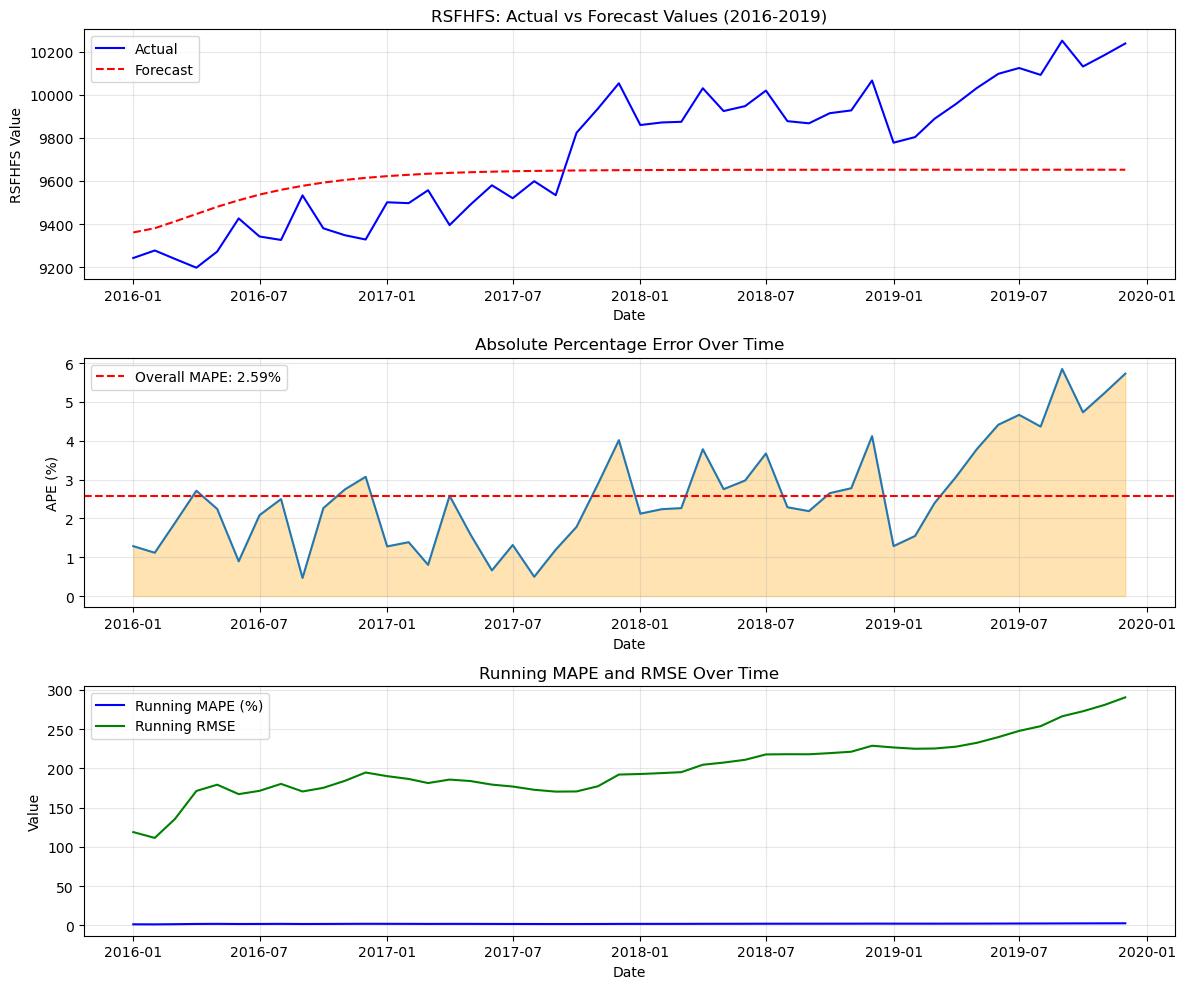

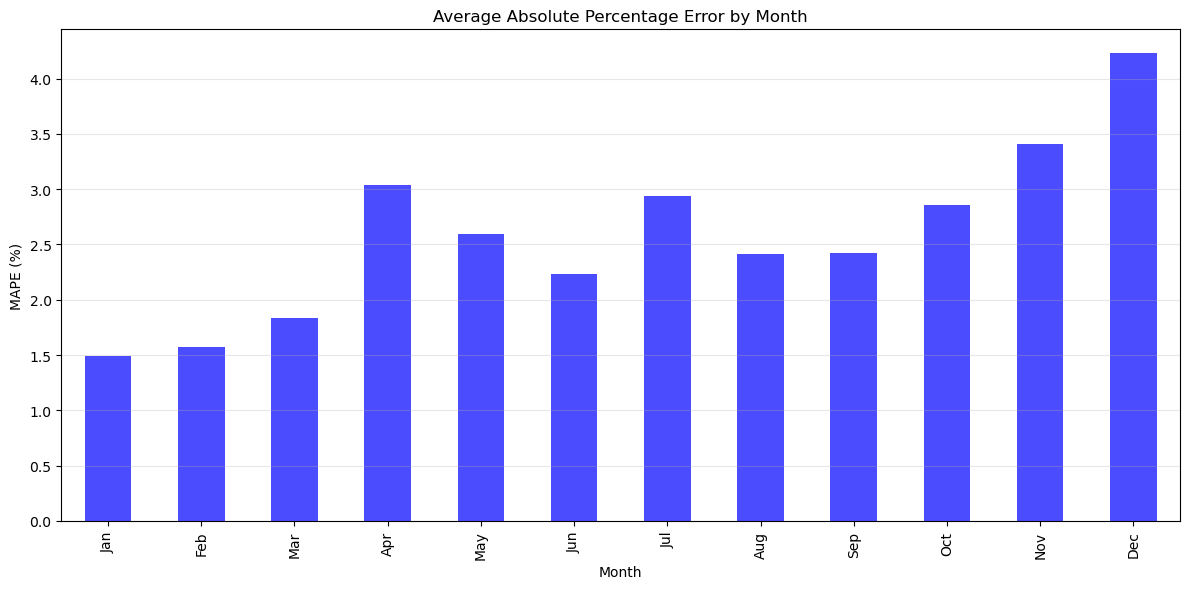

In [127]:
# d. Compute MAPE and RMSE
mape = mean_absolute_percentage_error(test_data['RSFHFS'], forecast_mean) * 100
rmse = np.sqrt(mean_squared_error(test_data['RSFHFS'], forecast_mean))

print("\nForecast Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Create a detailed table of actual vs predicted values with errors
comparison = pd.DataFrame({
    'Actual': test_data['RSFHFS'].values,
    'Forecast': forecast_mean.values,
    'Absolute Error': np.abs(test_data['RSFHFS'].values - forecast_mean.values),
    'Squared Error': (test_data['RSFHFS'].values - forecast_mean.values)**2,
    'Absolute Percentage Error': np.abs((test_data['RSFHFS'].values - forecast_mean.values) / test_data['RSFHFS'].values) * 100
})

comparison.index = test_data.index

# Calculate cumulative and running metrics
running_mape = []
running_rmse = []

for i in range(1, len(comparison) + 1):
    subset = comparison.iloc[:i]
    running_mape.append(subset['Absolute Percentage Error'].mean())
    running_rmse.append(np.sqrt(subset['Squared Error'].mean()))

# Add running metrics to the dataframe
comparison['Running MAPE'] = running_mape
comparison['Running RMSE'] = running_rmse

# Print detailed metrics
print("\nDetailed Error Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print("\nError Statistics:")
error_stats = comparison[['Absolute Error', 'Squared Error', 'Absolute Percentage Error']].describe()
print(error_stats)

# Visualize the error metrics over time
plt.figure(figsize=(12, 10))

# Plot 1: Actual vs Forecast
plt.subplot(3, 1, 1)
plt.plot(test_data.index, test_data['RSFHFS'], label='Actual', color='blue')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red', linestyle='--')
plt.title('RSFHFS: Actual vs Forecast Values (2016-2019)')
plt.xlabel('Date')
plt.ylabel('RSFHFS Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Absolute Percentage Error over time
plt.subplot(3, 1, 2)
plt.plot(comparison.index, comparison['Absolute Percentage Error'])
plt.axhline(y=mape, color='r', linestyle='--', label=f'Overall MAPE: {mape:.2f}%')
plt.fill_between(comparison.index, 0, comparison['Absolute Percentage Error'], alpha=0.3, color='orange')
plt.title('Absolute Percentage Error Over Time')
plt.xlabel('Date')
plt.ylabel('APE (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Running MAPE and RMSE
plt.subplot(3, 1, 3)
plt.plot(comparison.index, comparison['Running MAPE'], label='Running MAPE (%)', color='blue')
plt.plot(comparison.index, comparison['Running RMSE'], label='Running RMSE', color='green')
plt.title('Running MAPE and RMSE Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rsfhfs_error_metrics.png')

# Monthly breakdown of errors to look for seasonal patterns
comparison['Month'] = comparison.index.month
monthly_errors = comparison.groupby('Month')[['Absolute Error', 'Absolute Percentage Error']].mean()
monthly_errors.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 1, 1)
monthly_errors['Absolute Percentage Error'].plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
plt.title('Average Absolute Percentage Error by Month')
plt.xlabel('Month')
plt.ylabel('MAPE (%)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('rsfhfs_monthly_errors.png')

print("\nMonthly Error Analysis:")
print(monthly_errors)

# Yearly breakdown of errors
comparison['Year'] = comparison.index.year
yearly_errors = comparison.groupby('Year')[['Absolute Error', 'Absolute Percentage Error']].mean()

print("\nYearly Error Analysis:")
print(yearly_errors)

# Output a summary of the findings
print("\nSummary of Forecast Evaluation:")
print(f"1. Overall MAPE: {mape:.2f}% - This indicates that, on average, the forecasts deviate from the actual values by {mape:.2f}%")
print(f"2. Overall RMSE: {rmse:.2f} - This is the square root of the average squared differences between predicted and actual values")
print(f"3. Worst performing month: {monthly_errors['Absolute Percentage Error'].idxmax()} with MAPE of {monthly_errors['Absolute Percentage Error'].max():.2f}%")
print(f"4. Best performing month: {monthly_errors['Absolute Percentage Error'].idxmin()} with MAPE of {monthly_errors['Absolute Percentage Error'].min():.2f}%")
print(f"5. Worst performing year: {yearly_errors['Absolute Percentage Error'].idxmax()} with MAPE of {yearly_errors['Absolute Percentage Error'].max():.2f}%")
print(f"6. Best performing year: {yearly_errors['Absolute Percentage Error'].idxmin()} with MAPE of {yearly_errors['Absolute Percentage Error'].min():.2f}%")

# Save the error metrics to a CSV file for further analysis
comparison.to_csv('rsfhfs_forecast_errors.csv')

## Answer:

The forecast evaluation for the ARIMA(2,1,2) model of RSFHFS data yielded a Mean Absolute Percentage Error (MAPE) of 2.59% and Root Mean Squared Error (RMSE) of 290.54. These metrics reveal a moderately accurate forecast overall, though with notable temporal patterns in the error distribution. As shown in the plots, forecast errors increased substantially over time, with the model consistently underpredicting values after mid-2017, and error magnitudes growing significantly in late 2019 (reaching nearly 6%). This pattern is further confirmed by the running RMSE plot, which shows the error metric climbing from around 150 in early 2017 to nearly 300 by the end of 2019. The monthly analysis reveals December as the worst performing month (MAPE: 4.23%) and January as the best (MAPE: 1.49%), suggesting potential seasonal factors not captured by the model. Similarly, yearly performance degraded from 2017 (MAPE: 1.67%) to 2019 (MAPE: 3.92%), indicating the model's diminishing accuracy as the forecast horizon extended further from the training data.